<a href="https://colab.research.google.com/github/GOUTAM-RAM21/C--CODE-PRATICE/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

import opendatasets as od

od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: goutamsinghrajput
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.18GB/s]

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [12]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")
train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"]   = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

train_df.head()


,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(dataframe["category"]).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path)

        if self.transform:
            image = (self.transform(image) / 255.0).to(device)

        return image, label


In [15]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=transform)
val_dataset   = CustomImageDataset(dataframe=val_df, transform=transform)


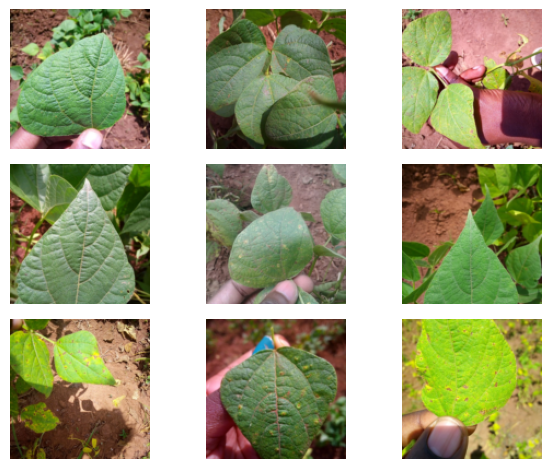

In [17]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = train_dataset[np.random.randint(0, len(train_dataset))][0].cpu()
        axarr[row, col].imshow((image * 255.0).squeeze().permute(1, 2, 0))
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [18]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15


In [19]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [20]:
googlenet_model = models.googlenet(weights='DEFAULT')


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 126MB/s]


In [21]:
for param in googlenet_model.parameters():
    param.requires_grad = True


In [22]:
googlenet_model.fc


Linear(in_features=1024, out_features=1000, bias=True)

In [23]:
num_classes = len(train_df["category"].unique())
num_classes


3

In [24]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc


Linear(in_features=1024, out_features=3, bias=True)

In [25]:
googlenet_model.to(device)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [26]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr = LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = googlenet_model(inputs)
        train_loss = loss_fun(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        optimizer.step()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_acc_train_plot.append(
        round((total_acc_train / train_dataset.__len__()) * 100, 4)
    )

    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {round(total_loss_train/1000, 4)}, "
        f"Train Accuracy: {round((total_acc_train/train_dataset.__len__()) * 100, 4)} %"
    )


Epoch 1/15, Train Loss: 0.2511, Train Accuracy: 54.4487 %
Epoch 2/15, Train Loss: 0.2191, Train Accuracy: 61.0251 %
Epoch 3/15, Train Loss: 0.2121, Train Accuracy: 64.7969 %
Epoch 4/15, Train Loss: 0.2075, Train Accuracy: 65.9574 %
Epoch 5/15, Train Loss: 0.1721, Train Accuracy: 71.3733 %
Epoch 6/15, Train Loss: 0.171, Train Accuracy: 71.6634 %
Epoch 7/15, Train Loss: 0.1561, Train Accuracy: 74.4681 %
Epoch 8/15, Train Loss: 0.1443, Train Accuracy: 76.3056 %
Epoch 9/15, Train Loss: 0.1477, Train Accuracy: 77.6596 %
Epoch 10/15, Train Loss: 0.1393, Train Accuracy: 80.9478 %
Epoch 11/15, Train Loss: 0.1212, Train Accuracy: 82.4952 %
Epoch 12/15, Train Loss: 0.1257, Train Accuracy: 80.6576 %
Epoch 13/15, Train Loss: 0.1197, Train Accuracy: 84.0426 %
Epoch 14/15, Train Loss: 0.1139, Train Accuracy: 83.559 %
Epoch 15/15, Train Loss: 0.0983, Train Accuracy: 85.4932 %


In [40]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for input, labels in val_loader:
        prediction = googlenet_model(input)

        acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
        total_acc_test += acc

print(round(total_acc_test / val_dataset.__len__() * 100, 2))


84.21
